In [47]:
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import pdist, squareform
from scipy.sparse.csgraph import minimum_spanning_tree
import networkx as nx
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

In [48]:
df = pd.read_csv('/Users/walidahmed/Documents/Documents/DataScience/24_25midfielder.csv')  

In [49]:
df = df[df['90s'] > 10]

In [50]:
features = [
    'xA',              # expected assists per 90
    'KP',              # key passes per 90
    'SCA',             # shot-creating actions per 90
    'PPA',             # passes into penalty area per 90
    'PrgP',            # progressive passes completed per 90
    'PrgC',            # progressive carries per 90
    'TcklW',           # tackles won per 90
    'Int',             # interceptions per 90
    'ShortCmp',        # short passes completed per 90
    'MedCmp',          # medium passes completed per 90
    'LongCmp',         # long passes completed per 90
    'xAG',             # expected assisted goals per 90
    '1/3P',            # passes into final third per 90
    'CrsPA',           # crosses into penalty area per 90
    'SuccTkon',        # succesful takeons per 90
    '1/3C',            # carries into final third per 90
    'CPA',             # carries into penatly area per 90
    'PrgR'             # progressive passes received per 90
]
X = df[features].dropna()
player_names = df.loc[X.index, 'Player']

In [51]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [52]:
k = 5
kmeans = KMeans(n_clusters=k, random_state=42)
clusters = kmeans.fit_predict(X_scaled)
df['Cluster'] = clusters

/Users/walidahmed/.local/share/virtualenvs/DataScience-Kz5g2voH/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [53]:
centers = pd.DataFrame(
    kmeans.cluster_centers_,
    columns=features
)
centers['Cluster'] = centers.index.astype(str)   #string so seaborn treats them as categories

#“melt” into long form
df_centers = centers.melt(
    id_vars='Cluster',
    var_name='feature',
    value_name='z_val')

/Users/walidahmed/.local/share/virtualenvs/DataScience-Kz5g2voH/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


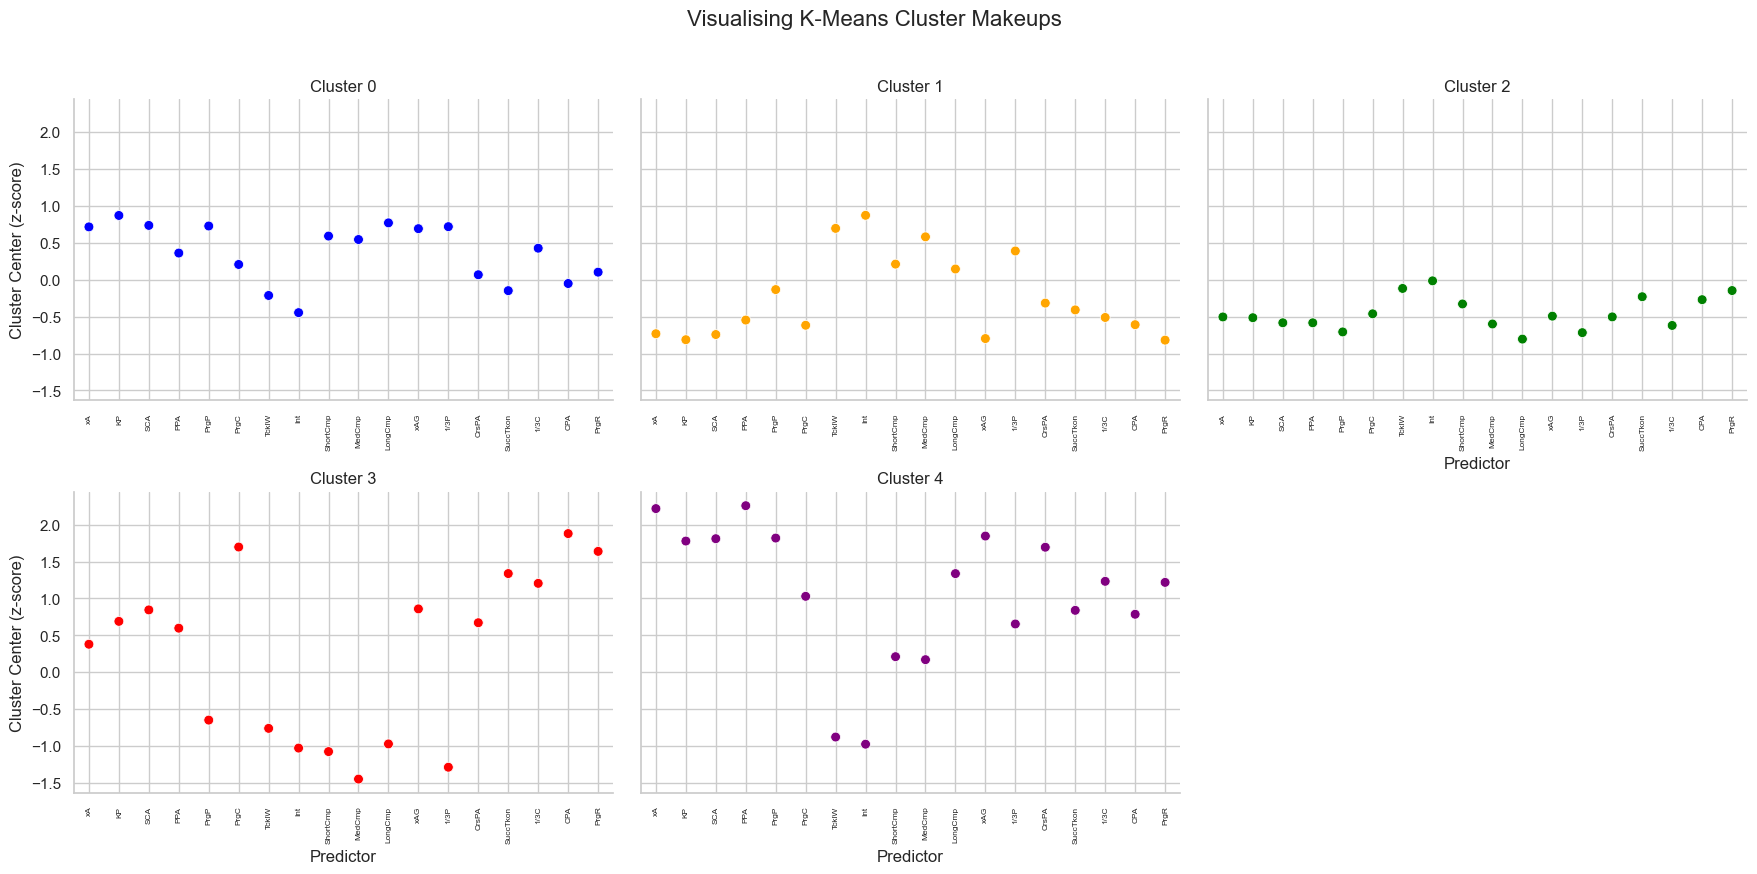

In [59]:
sns.set_theme(style='whitegrid')

cluster_palette = {
    '0': 'blue',
    '1': 'orange',
    '2': 'green',
    '3': 'red',
    '4': 'purple'
}

#sharex=False so each facet draws its own x-axis
g = sns.FacetGrid(
    df_centers,
    col='Cluster',
    col_wrap=3,
    sharey=True,
    sharex=False,
    height=3,
    aspect=1.4
)

g.map_dataframe(
    sns.scatterplot,
    x='feature',
    y='z_val',
    hue='Cluster',
    palette=cluster_palette,
    legend=False,
    s=50
)

for ax in g.axes.flatten():
    ax.set_xticks(range(len(features)))
    ax.set_xticklabels(features, rotation=90, fontsize=6)
    ax.set_xlim(-0.5, len(features) - 0.5)

g.set_axis_labels("Predictor", "Cluster Center (z-score)")
g.set_titles("Cluster {col_name}")

g.figure.set_size_inches(18, 9)
g.figure.subplots_adjust(top=0.88)
g.figure.suptitle("Visualising K-Means Cluster Makeups", fontsize=16)

plt.show()

In [60]:
dist_matrix = squareform(pdist(X_scaled, metric='euclidean'))
mst_sparse = minimum_spanning_tree(dist_matrix)
G = nx.from_scipy_sparse_array(mst_sparse)

In [61]:
pca = PCA(n_components=2, random_state=42)
coords = pca.fit_transform(X_scaled)
pos = {i: coords[i] for i in range(len(coords))}

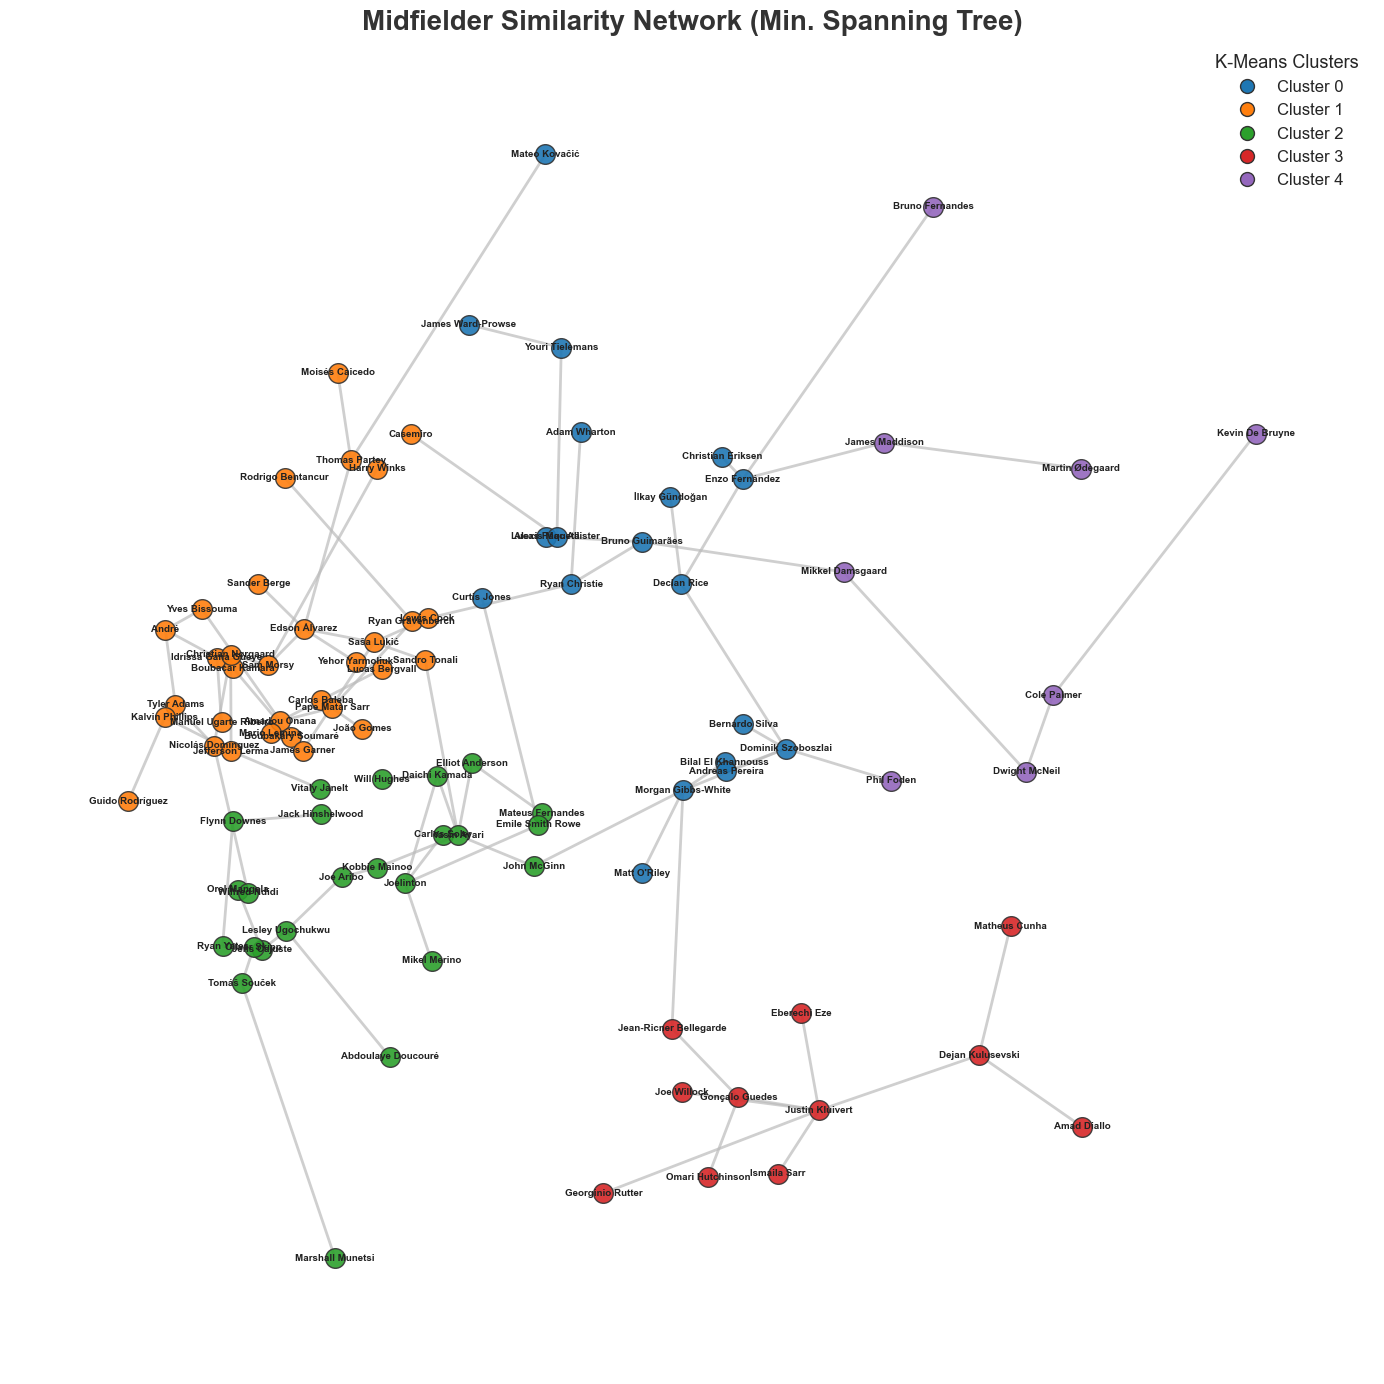

In [62]:
cluster_palette = {
    0: "#1f77b4",  # blue
    1: "#ff7f0e",  # orange
    2: "#2ca02c",  # green
    3: "#d62728",  # red
    4: "#9467bd",  # purple
}

plt.figure(figsize=(14, 14))
ax = plt.gca()
ax.set_facecolor("#f7f7f7")  
plt.title("Midfielder Similarity Network (Min. Spanning Tree)", 
          fontdict={"fontsize": 20, "fontweight": "bold", "color": "#333333"}
)

nx.draw_networkx_edges(
    G, pos,
    ax=ax,
    edge_color="#BBBBBB",
    width=2,
    alpha=0.7
)


for cluster_id, color in cluster_palette.items():
    node_list = [i for i, c in enumerate(clusters) if c == cluster_id]
    nx.draw_networkx_nodes(
        G, pos,
        nodelist=node_list,
        node_size=200,
        node_color=color,
        edgecolors="#333333",
        linewidths=1.0,
        alpha=0.9,
        ax=ax
    )

nx.draw_networkx_labels(
    G, pos,
    labels={i: name for i, name in enumerate(player_names)},
    font_size=7,
    font_weight="bold",
    font_family="sans-serif",
    font_color="#222222",
    ax=ax
)

ax.set_xticks([])
ax.set_yticks([])
ax.axis("off")

from matplotlib.lines import Line2D
legend_handles = [
    Line2D([0], [0],
           marker="o",
           color="w",
           markerfacecolor=cluster_palette[i],
           markeredgecolor="#333333",
           markersize=10,
           label=f"Cluster {i}")
    for i in sorted(cluster_palette)
]
ax.legend(
    handles=legend_handles,
    loc="upper right",
    title="K-Means Clusters",
    frameon=False,
    fontsize=12,
    title_fontsize=13
)

plt.tight_layout()
plt.show()

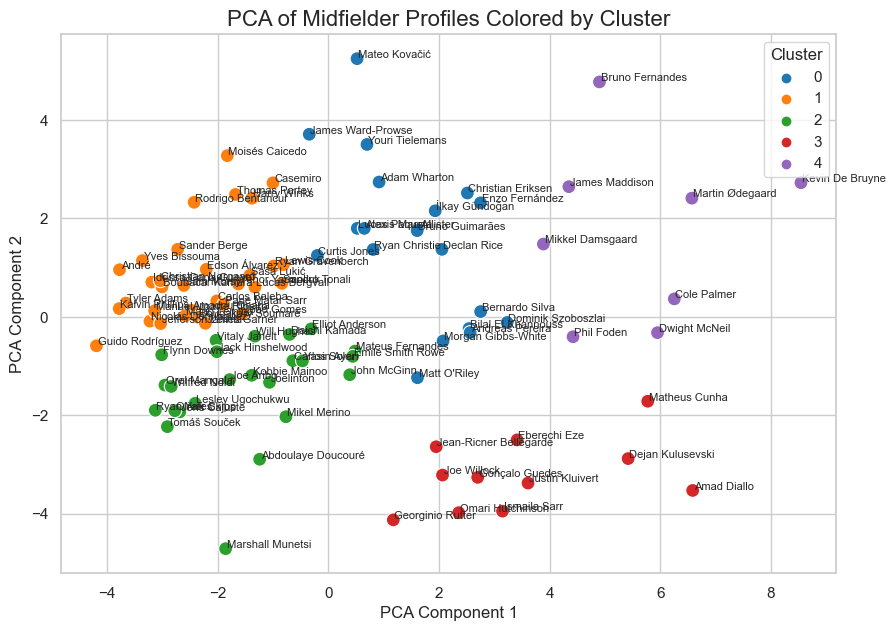

In [63]:
plt.figure(figsize=(10, 7))
sns.scatterplot(x=coords[:, 0], y=coords[:, 1], hue=clusters, palette=cluster_palette, s=100)
for i, name in enumerate(player_names):
    plt.text(coords[i, 0] + 0.02, coords[i, 1] + 0.02, name, fontsize=8)
plt.title('PCA of Midfielder Profiles Colored by Cluster', fontsize=16)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster')
plt.show()